In [1]:
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import hnn_core
from hnn_core import calcium_model, simulate_dipole, read_params, pick_connection
from hnn_core.network_models import add_erp_drives_to_jones_model
from hnn_core.network_builder import NetworkBuilder
from hnn_core.cell import _get_gaussian_connection
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import utils
from utils import (SingleNeuron_Data, Network_Data, CellType_Dataset_Fast,
                   linear_scale_forward, log_scale_forward, UniformPrior, section_drive_param_function)
import multiprocessing
from typing import Dict, Tuple, Optional, List
from utils import ConcatTensorDataset
from TCN.tcn import model_TCN

device = torch.device("cuda:0")
# device = 'cpu'
num_cores = multiprocessing.cpu_count()
torch.backends.cudnn.enabled = True

--No graphics will be displayed.


In [2]:
dataset_type = 'connected'
dataset_indices = list(range(920,940))

model_dict, dataset_dict = dict(), dict()
cell_type_list = ['L5_pyramidal']
for cell_type in cell_type_list:
    cell_type_dataset = torch.utils.data.ConcatDataset(
        [torch.load(f'/users/ntolley/scratch/bayesian_surrogates/datasets_{dataset_type}/training_data/{cell_type}_dataset_{idx}.pt') for
         idx in dataset_indices])
    dataset_dict[cell_type] = cell_type_dataset

    _, input_size = cell_type_dataset[0][0].detach().cpu().numpy().shape
    _, output_size = cell_type_dataset[0][1].detach().cpu().numpy().shape

    seq_len = 800
    model_dict[cell_type] = model_TCN(input_size, output_size, num_channels=[32,32,32], kernel_size=20, dropout=0.2, seq_len=seq_len).to(device)
    model_dict[cell_type].load_state_dict(torch.load(f'subthreshold_models/{cell_type}_subthreshold_model.pt'))
    model_dict[cell_type].to(device)

In [5]:
def run_model(model, validation_set):
    val_data = validation_set[:][0][:,:,:].float().to(device)
    with torch.no_grad():
        model.eval()
        output_sequence = []
        h0 = torch.zeros(model.n_lstm_layers, 9, model.lstm_hidden_dim).to(device)
        c0 = torch.zeros(model.n_lstm_layers, 9, model.lstm_hidden_dim).to(device)
        output_sequence = model(val_data, h0, c0)
        # for t in range(model.kernel_size, val_data.size(1)):
        #     output, h0, c0 = model(val_data[:,(t-model.kernel_size):t, :], h0, c0)
        #     output_sequence.append(output)

        # output_sequence = torch.cat(output_sequence, dim=1)

    return output_sequence


In [6]:
cell_type = 'L5_pyramidal'
model = model_dict[cell_type]
validation_data = dataset_dict[cell_type].datasets[0]
pred = run_model(model, validation_data)

# # plt.imshow(validation_data[0][0].detach().cpu().numpy().T, aspect='auto')
# # plt.colorbar()

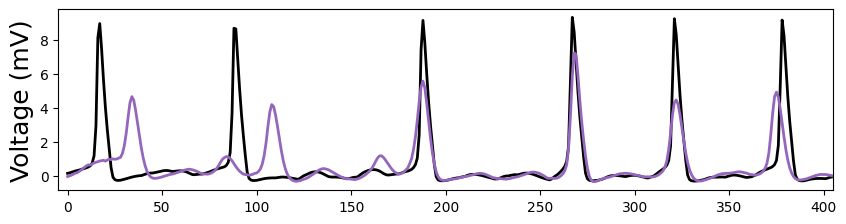

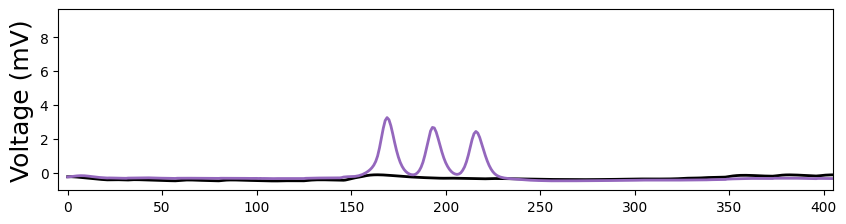

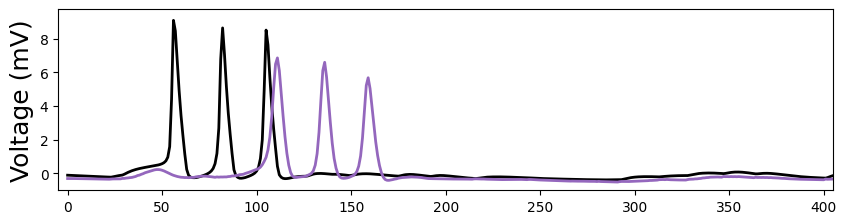

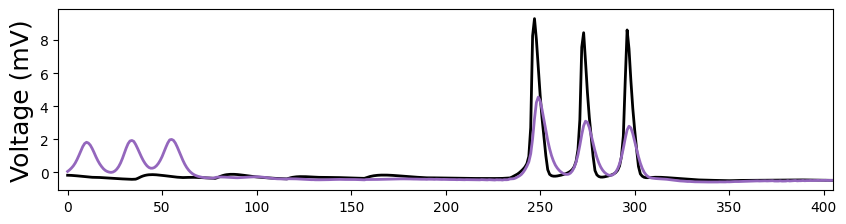

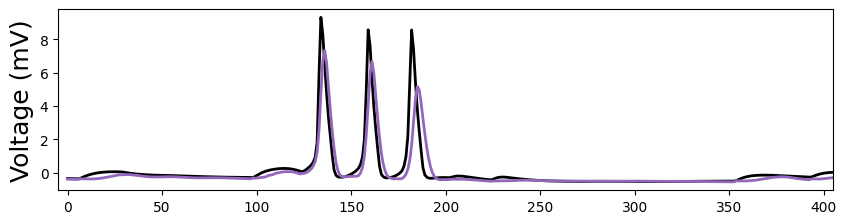

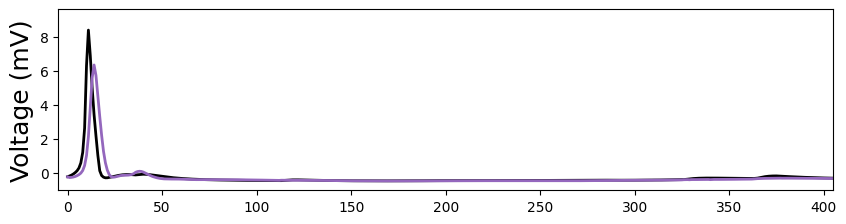

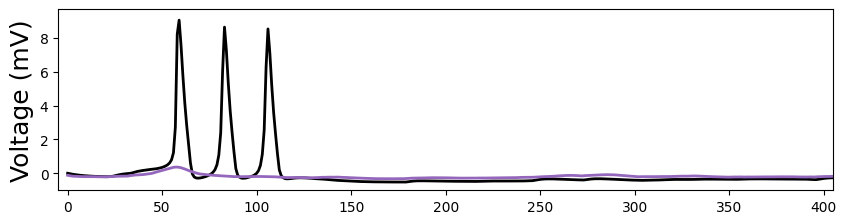

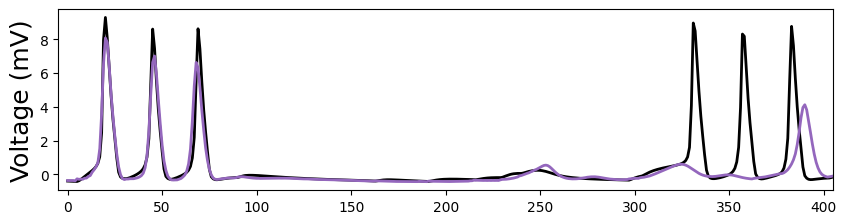

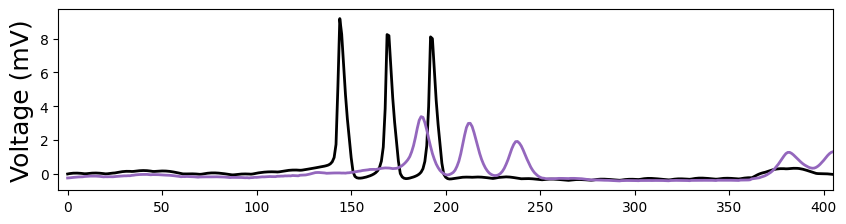

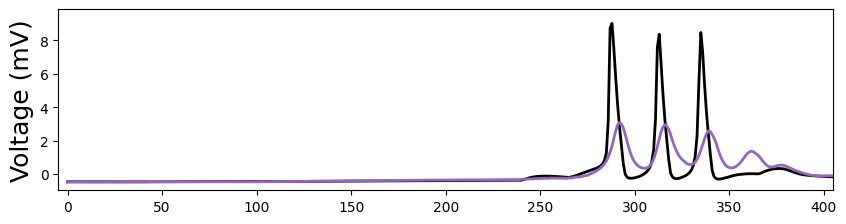

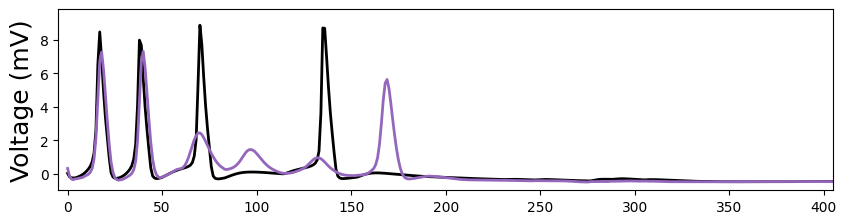

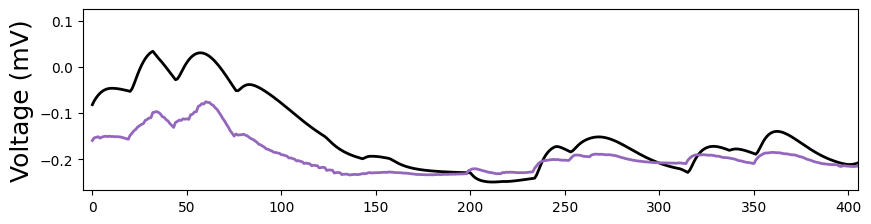

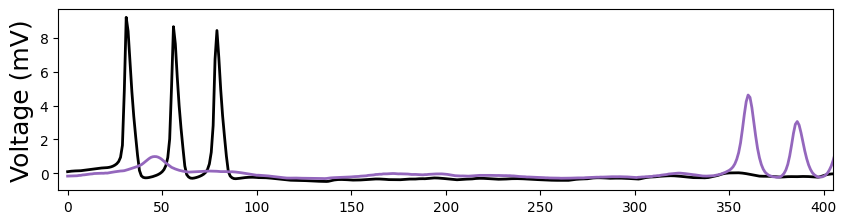

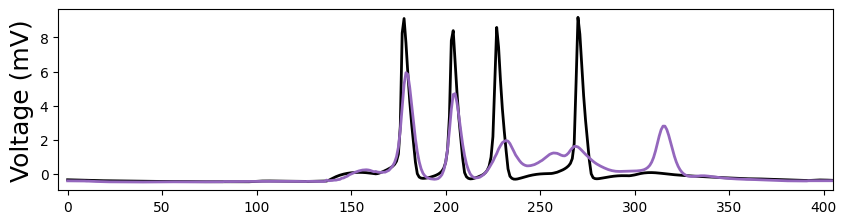

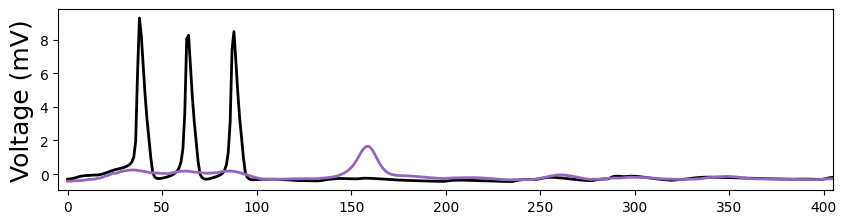

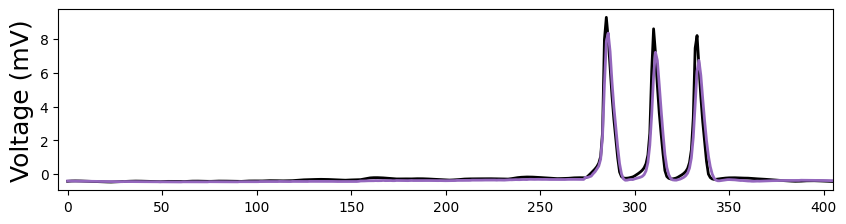

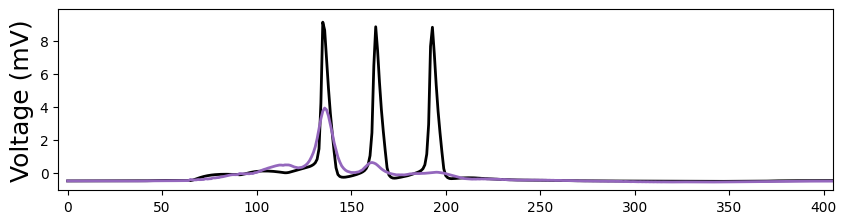

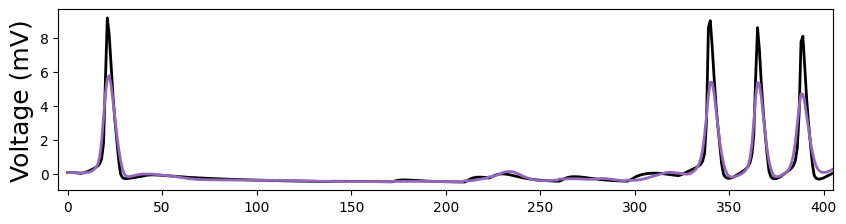

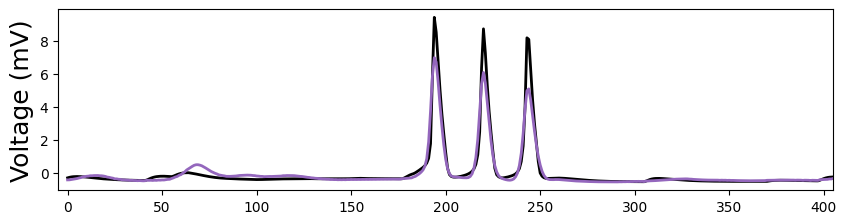

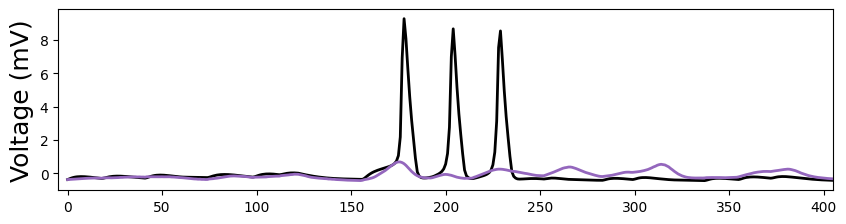

In [9]:
for plot_idx in list(range(0,20)):
    validation_data = dataset_dict[cell_type].datasets[-plot_idx]
    pred, _, _ = run_model(model, validation_data)

    cell_idx = 1
    hnn_color = 'k'
    ann_color = 'C4'

    plot_xlim = (-5,405)
    linewidth = 2
    fontsize=18

    plt.figure(figsize=(10,8))
    plt.subplot(3,1,1)
    sec_idx = 0
    plt.plot(validation_data[cell_idx][1][model.seq_len:, sec_idx].detach().cpu().numpy(), label = 'HNN', color=hnn_color, linewidth=linewidth)
    plt.plot(pred[cell_idx, model.seq_len:, sec_idx].detach().cpu().numpy(), label = 'ANN', color=ann_color, linewidth=linewidth)
    # plt.xticks([])
    # plt.yticks([])
    plt.ylabel('Voltage (mV)', fontsize=fontsize)
    plt.xlim(plot_xlim)
    # plt.ylim(-5,5)

    # plt.savefig('single_cell_prediction.svg')


(-5.0, 405.0)

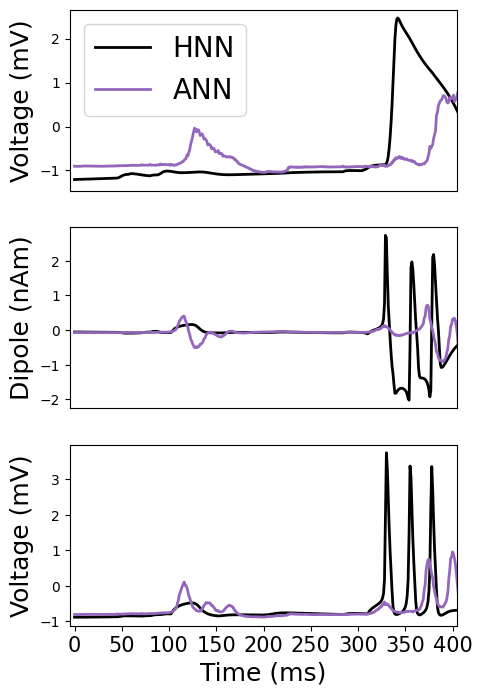

In [48]:
# cell_idx = 4
cell_idx = 1

validation_data = dataset_dict[cell_type].datasets[11]
pred = run_model(model, validation_data)

hnn_color = 'k'
ann_color = 'C4'

plot_xlim = (-5,405)
linewidth = 2
fontsize=18

plt.figure(figsize=(5,8))
plt.subplot(3,1,1)
sec_idx = 3
plt.plot(validation_data[cell_idx][1][model.seq_len:, sec_idx].detach().cpu().numpy(), label = 'HNN', color=hnn_color, linewidth=linewidth)
plt.plot(pred[cell_idx, model.seq_len:, sec_idx].detach().cpu().numpy(), label = 'ANN', color=ann_color, linewidth=linewidth)
plt.xticks([])
# plt.yticks([])
plt.ylabel('Voltage (mV)', fontsize=fontsize)
plt.xlim(plot_xlim)

plt.legend(fontsize=20)

plt.subplot(3,1,2)
sec_idx = 9
plt.plot(validation_data[cell_idx][1][model.seq_len:, sec_idx].detach().cpu().numpy(), label = 'HNN', color=hnn_color, linewidth=linewidth)
plt.plot(pred[cell_idx, model.seq_len:, sec_idx].detach().cpu().numpy(), label = 'ANN', color=ann_color, linewidth=linewidth)
plt.xticks([])
# plt.yticks([])
plt.ylabel('Dipole (nAm)',fontsize=fontsize)
plt.xlim(plot_xlim)


plt.subplot(3,1,3)
sec_idx = 8
plt.plot(validation_data[cell_idx][1][model.seq_len:, sec_idx].detach().cpu().numpy(), label = 'HNN', color=hnn_color, linewidth=linewidth)
plt.plot(pred[cell_idx, model.seq_len:, sec_idx].detach().cpu().numpy(), label = 'ANN', color=ann_color, linewidth=linewidth)
plt.xticks(size=15)
# plt.yticks([])
plt.xlabel('Time (ms)', fontsize=fontsize)
plt.ylabel('Voltage (mV)', fontsize=fontsize)
plt.xlim(plot_xlim)

# plt.savefig('single_cell_prediction.svg')


In [72]:
pred.shape

torch.Size([63, 300, 10])

In [73]:
print('Apical tuft corr: ', end='')
sec_idx = 3
print(np.corrcoef(validation_data[:][1][:,200:, sec_idx].detach().cpu().numpy().flatten(), pred[:, :, sec_idx].detach().cpu().numpy().flatten())[0,1])

print('Dipole corr: ', end='')
sec_idx = 9
print(np.corrcoef(validation_data[:][1][:,200:, sec_idx].detach().cpu().numpy().flatten(), pred[:, :, sec_idx].detach().cpu().numpy().flatten())[0,1])

print('Soma corr: ', end='')
sec_idx = 8
print(np.corrcoef(validation_data[:][1][:,200:, sec_idx].detach().cpu().numpy().flatten(), pred[:, :, sec_idx].detach().cpu().numpy().flatten())[0,1])

Apical tuft corr: 0.9157100134422306
Dipole corr: 0.7648997811402286
Soma corr: 0.7876907668639423


(-5.0, 1000.0)

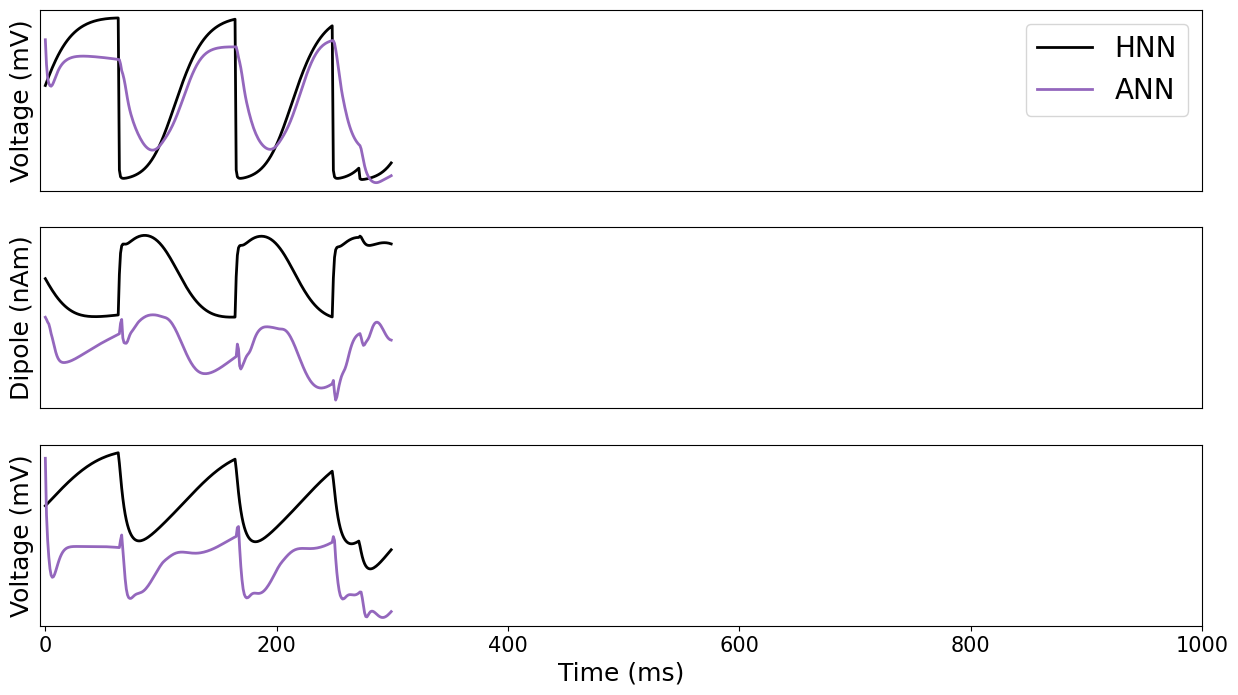

In [14]:
# cell_idx = 4
cell_idx = 22

hnn_color = 'k'
ann_color = 'C4'

plot_xlim = (-5,1000)
linewidth = 2
fontsize=18

plt.figure(figsize=(15,8))
plt.subplot(3,1,1)
sec_idx = 3
plt.plot(validation_data[cell_idx][1][200:, sec_idx].detach().cpu().numpy(), label = 'HNN', color=hnn_color, linewidth=linewidth)
plt.plot(pred[cell_idx, :, sec_idx].detach().cpu().numpy(), label = 'ANN', color=ann_color, linewidth=linewidth)
plt.xticks([])
plt.yticks([])
plt.ylabel('Voltage (mV)', fontsize=fontsize)
plt.xlim(plot_xlim)

plt.legend(fontsize=20)

plt.subplot(3,1,2)
sec_idx = 9
plt.plot(validation_data[cell_idx][1][200:, sec_idx].detach().cpu().numpy(), label = 'HNN', color=hnn_color, linewidth=linewidth)
plt.plot(pred[cell_idx, :, sec_idx].detach().cpu().numpy(), label = 'ANN', color=ann_color, linewidth=linewidth)
plt.xticks([])
plt.yticks([])
plt.ylabel('Dipole (nAm)',fontsize=fontsize)
plt.xlim(plot_xlim)


plt.subplot(3,1,3)
sec_idx = 8
plt.plot(validation_data[cell_idx][1][200:, sec_idx].detach().cpu().numpy(), label = 'HNN', color=hnn_color, linewidth=linewidth)
plt.plot(pred[cell_idx, :, sec_idx].detach().cpu().numpy(), label = 'ANN', color=ann_color, linewidth=linewidth)
plt.xticks(size=15)
plt.yticks([])
plt.xlabel('Time (ms)', fontsize=fontsize)
plt.ylabel('Voltage (mV)', fontsize=fontsize)
plt.xlim(plot_xlim)

